In [18]:
# Load libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Load the CSVs containing image filenames and labels
TRAIN_CSV = "../data/Training_set.csv"
TEST_CSV  = "../data/Testing_set.csv"
TRAIN_DIR = "../data/train"
TEST_DIR  = "../data/test"

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print(train_df.head())
print(test_df.head())
print(train_df['label'].nunique(), "classes")

      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg
75 classes


In [19]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Turn into Keras format: with "filename" and "class" as column names
train_df = train_df.rename(columns={"Image": "filename", "label": "class"})
test_df  = test_df.rename(columns={"Image": "filename"})

# Split train data into training and validation sets
from sklearn.model_selection import train_test_split

train_df_split, val_df_split = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['class'],
    random_state=123
)

# Image normalizing (rescale pixel values 0–255 -> 0–1)
train_datagen = ImageDataGenerator(
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators that read images directly from folders
# Keras loads + preprocesses images for us automatically
train_gen = train_datagen.flow_from_dataframe(
    train_df_split,
    directory=TRAIN_DIR,
    x_col="filename",
    y_col="class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df_split,
    directory=TRAIN_DIR,
    x_col="filename",
    y_col="class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Total number of output classes
num_classes = train_df_split["class"].nunique()
print("Number of classes:", num_classes)

# Test generator – IMPORTANT: shuffle=False to preserve CSV order
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    directory=TEST_DIR,
    x_col="filename",
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Number of classes: 75
Found 2786 validated image filenames.


In [20]:
from tensorflow.keras import layers, models

# Function to build a CNN with variable depth
# Allows us to test how model complexity affects performance
def build_cnn(num_conv_blocks=3, base_filters=32, dense_units=256):
    model = models.Sequential()
    
    # First block (requires input shape)
    model.add(layers.Conv2D(base_filters, (3,3), activation='relu', 
                            input_shape=(*IMAGE_SIZE, 3)))
    model.add(layers.MaxPooling2D((2,2)))

    # Additional convolution blocks (filters double each block)
    filters = base_filters
    for i in range(num_conv_blocks - 1):
        filters *= 2
        model.add(layers.Conv2D(filters, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D((2,2)))
    
    # Classification head
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model# Train multiple CNNs with different depths
# (1, 2, 3, 4 convolution blocks)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
        
    return model

In [21]:
# Train multiple CNNs with different depths
# (1, 2, 3, 4 convolution blocks)
EPOCHS = 10
depths = [1, 2, 3, 4]
histories = {}

for d in depths:
    print(f"\nTraining model with {d} conv blocks...\n")
    model = build_cnn(num_conv_blocks=d)
    # Train and store history for comparing performance later
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS
    )
    histories[d] = history

    val_loss, val_acc = model.evaluate(val_gen)
    print(f"Validation accuracy for depth {d}: {val_acc:.4f}")



Training model with 1 conv blocks...

Epoch 1/10


/Users/oscarodonnell/Library/Python/3.12/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.0239 - loss: 4.8779 - val_accuracy: 0.0515 - val_loss: 4.0985
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.0454 - loss: 4.0435 - val_accuracy: 0.0915 - val_loss: 3.7361
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.0650 - loss: 3.7816 - val_accuracy: 0.1131 - val_loss: 3.5291
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.0844 - loss: 3.5834 - val_accuracy: 0.1792 - val_loss: 3.2389
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.1398 - loss: 3.3304 - val_accuracy: 0.2223 - val_loss: 3.0937
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.1570 - loss: 3.1323 - val_accuracy: 0.2531 - val_loss: 2.8756
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.1918 - loss: 2.9360 - val_accuracy: 0.2762 - val_loss: 2.8321
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.2256 - loss: 2.7661 - val_accuracy: 0

In [22]:
# Predict class probabilities
# Make predictions using the LAST trained model
pred_probs = model.predict(test_gen)

# Convert probabilities -> predicted class indices
pred_indices = np.argmax(pred_probs, axis=1)

# Map indices back to labels (strings)
index_to_class = {v: k for k, v in train_gen.class_indices.items()}
pred_labels = [index_to_class[i] for i in pred_indices]

# Attach to test_df in the same order
test_df['predicted_label'] = pred_labels

# Save to csv file
test_df.to_csv("../results/butterfly_predictions.csv", index=False)
print(test_df.head())

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
      filename         predicted_label
0  Image_1.jpg       COMMON BANDED AWL
1  Image_2.jpg           CRIMSON PATCH
2  Image_3.jpg                  ADONIS
3  Image_4.jpg         IPHICLUS SISTER
4  Image_5.jpg  MILBERTS TORTOISESHELL


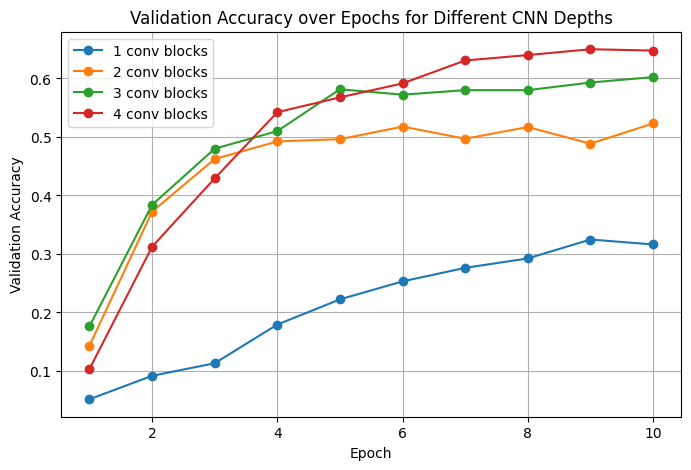

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for d, history in histories.items():
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, val_acc, marker="o", label=f"{d} conv blocks")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs for Different CNN Depths")
plt.legend()
plt.grid(True)
plt.show()
